## Preambule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import plotly.graph_objects as go

## Read data

In [2]:
year = '1990'

In [3]:
xr_total = xr.open_dataset(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / year / "xr_total.nc")
xr_budgets_scenario = xr.open_dataset(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / year / "xr_budgets_scenario.nc")
xr_budgets_static = xr.open_dataset(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / year / "xr_budgets_static.nc")
all_regions = np.load(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / year / "all_regions.npy")
all_countries = np.load(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / year / "all_countries.npy", allow_pickle=True)

## Check: missing data

In [4]:
df_missing = {}
df_missing['ISO3'] = xr_total.ISO
df_missing["Population_past"] = np.isnan(np.array(xr_total.Population.sel(Time=2000)))
df_missing["Population_future"] = np.isnan(np.array(xr_total.Population.sel(Time=2050)))
df_missing["GDP_past"] = np.isnan(np.array(xr_total.GDP.sel(Time=2000)))
df_missing["GDP_future"] = np.isnan(np.array(xr_total.GDP.sel(Time=2050)))
df_missing["Emissions_past"] = np.isnan(np.array(xr_total.GHG_p.sel(Time=2000)))
df_missing["HDI"] = np.isnan(np.array(xr_total.HDI))
df_missing["NDC"] = np.isnan(np.array(xr_total.NDC_h.sel(Time=2030)))

In [5]:
pd.DataFrame(df_missing).to_csv(Path("X:/user/dekkerm/Projects/ECEMF_T5.2/") / "Data" / "MissingData.csv")

In [6]:
for k in list(df_missing.keys())[1:]:
    print(k+':', np.round(np.sum(df_missing[k])/len(df_missing[k])*100,2), 'percent is missing ('+str(np.sum(df_missing[k]))+')')
print()
pop = np.array(xr_total.Population.sel(Time=2020))
for k in list(df_missing.keys())[1:]:
    popw = np.array(xr_total.Population.sel(Time=2020, ISO='WORLD'))
    print(k+':', np.round(np.nansum(df_missing[k]*1*pop)/popw*100,5), 'percent is missing ('+str(np.sum(df_missing[k]))+')')

Population_past: 0.0 percent is missing (0)
Population_future: 0.0 percent is missing (0)
GDP_past: 1.91 percent is missing (4)
GDP_future: 1.91 percent is missing (4)
Emissions_past: 0.48 percent is missing (1)
HDI: 3.35 percent is missing (7)
NDC: 0.96 percent is missing (2)

Population_past: 0.0 percent is missing (0)
Population_future: 0.0 percent is missing (0)
GDP_past: 0.00075 percent is missing (4)
GDP_future: 0.00075 percent is missing (4)
Emissions_past: 0.06392 percent is missing (1)
HDI: 0.24323 percent is missing (7)
NDC: 0.08518 percent is missing (2)


In [7]:
df_missing['ISO3'][df_missing['NDC']]

<xarray.DataArray 'ISO' (ISO: 2)>
array(['VAT', 'LBY'], dtype=object)
Coordinates:
  * ISO      (ISO) object 'VAT' 'LBY'

In [8]:
df_missing['ISO3'][df_missing['HDI']]

<xarray.DataArray 'ISO' (ISO: 7)>
array(['COK', 'VAT', 'MCO', 'NRU', 'NIU', 'SOM', 'GMB'], dtype=object)
Coordinates:
  * ISO      (ISO) object 'COK' 'VAT' 'MCO' 'NRU' 'NIU' 'SOM' 'GMB'

## Check: Fyson 2 behavior per country

## Check monotomy

In [8]:
def check_monotomy(reg, var):
    y0 = -1e8
    buds = []
    for c_i, c in enumerate(['C1+C2', 'C3', 'C5+C6', 'C7']):
        y1 = float(xr_budgets_static.sel(ISO=reg, Category=c)[var])
        buds.append(y1)
        if not np.isnan(y1) and y1 != 0:
            if y1 > y0:
                y0 = float(np.copy(y1))
                continue
            else:
                return 0
        else:
            return 2
    return 1

In [9]:
def check_monotomy_dynamic(reg, var, year):
    y0 = -1e8
    buds = []
    for c_i, c in enumerate(['C1+C2', 'C3', 'C5+C6', 'C7']):
        y1 = float(xr_budgets_scenario.sel(ISO=reg, Category=c, Time=year)[var])
        buds.append(y1)
        if not np.isnan(y1) and y1 != 0:
            if y1 > y0:
                y0 = float(np.copy(y1))
                continue
            else:
                return 0
        else:
            return 2
    return 1

In [10]:
for r_i, r in enumerate(all_regions):
    if check_monotomy(r, "F1g") == 0:
        print(0, r)
    if check_monotomy(r, "F1g") == 2:
        print(2, r)

2 COK
2 VAT
2 LIE
2 NIU


In [21]:
listc=[]
for r_i, r in enumerate(all_regions):
    if check_monotomy_dynamic(r, "F1g", 2030) == 0:
        print(0, r)
        listc.append(r)
    # if check_monotomy_dynamic(r, "F1g", 2030) == 2:
    #     print(2, r)

0 AFG
0 BGD
0 BEN
0 BFA
0 BDI
0 CMR
0 CPV
0 COM
0 CIV
0 COD
0 ERI
0 ETH
0 GHA
0 GIN
0 GNB
0 HTI
0 KEN
0 KIR
0 LBR
0 MDG
0 MWI
0 MLI
0 MOZ
0 NPL
0 NER
0 NGA
0 PAK
0 PSE
0 PNG
0 RWA
0 STP
0 SEN
0 SLE
0 SLB
0 SOM
0 TJK
0 TZA
0 GMB
0 TGO
0 UGA
0 VUT
0 YEM
0 ZMB
0 CVF
0 LDC


IndexError: index 12 is out of bounds for axis 0 with size 12

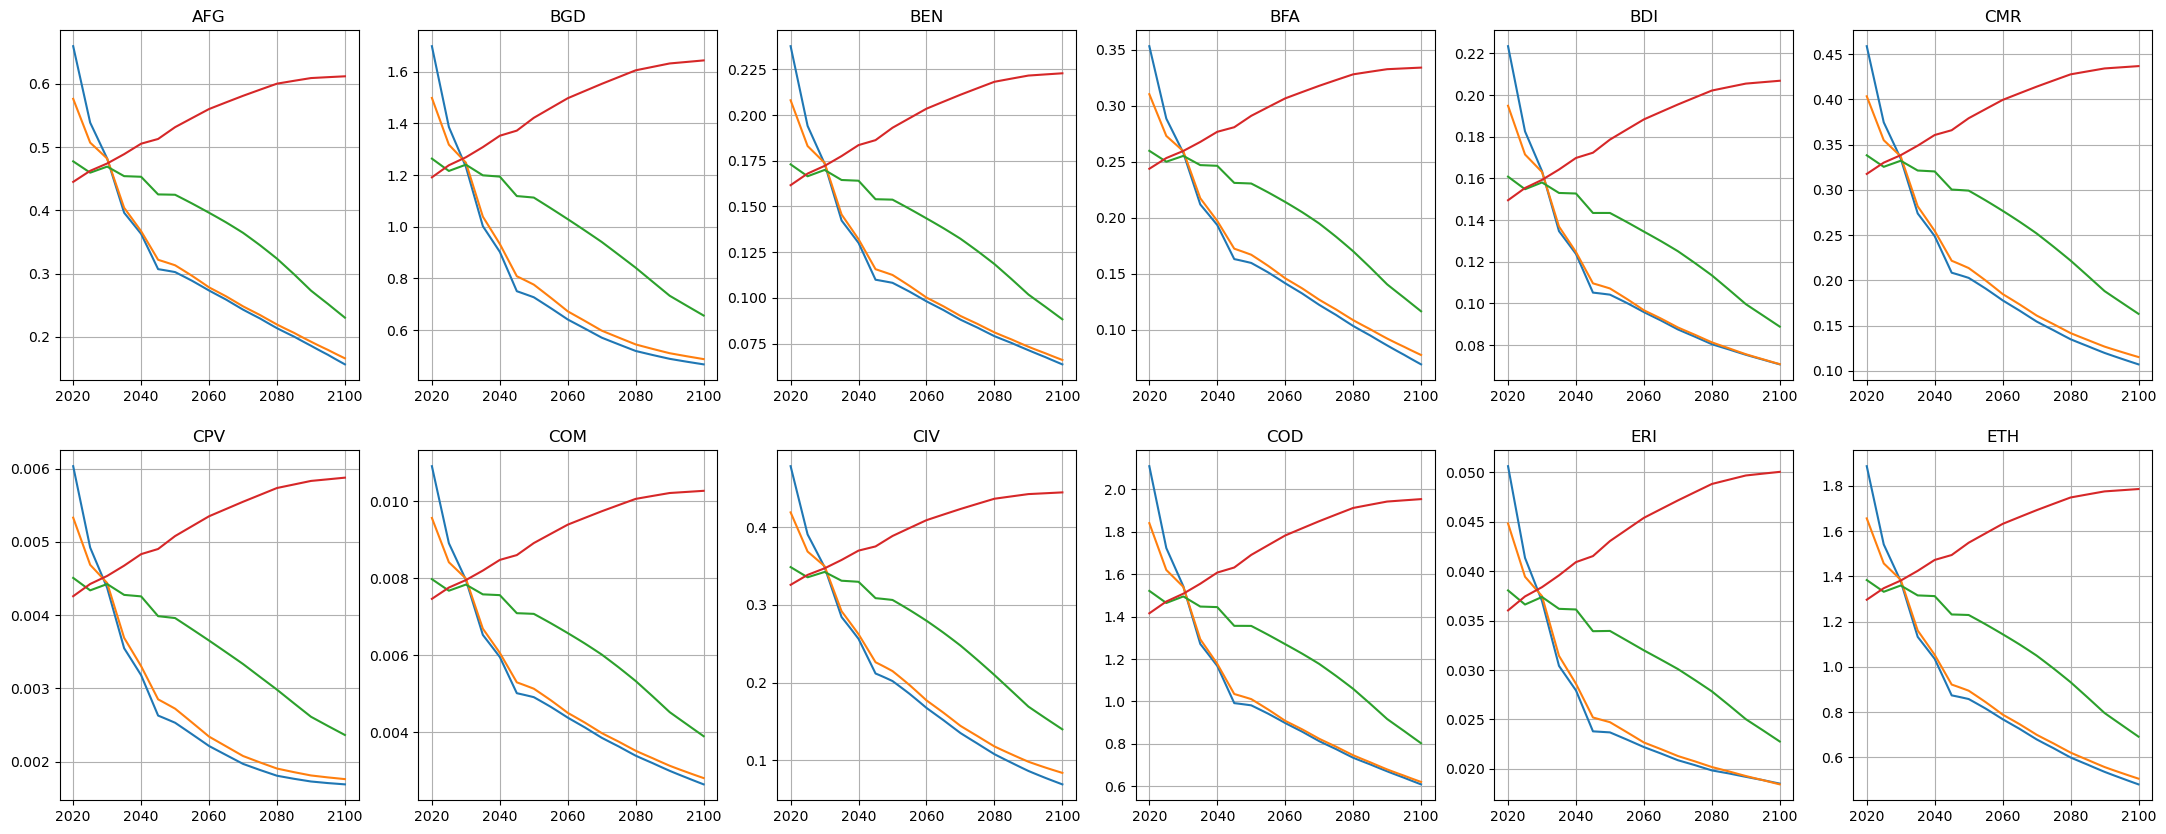

In [22]:
var = 'F1g'
fig, axes = plt.subplots(2, 6, figsize=(27, 10))
for r_i, r in enumerate(listc):
    ax = axes.flatten()[r_i]
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(ISO=r, Category='C1+C2')[var], label='C1+C2')
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(ISO=r, Category='C3')[var], label="C3")
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(ISO=r, Category='C5+C6')[var], label="C5+C6")
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(ISO=r, Category='C7')[var], label="C7")
    ax.grid(True)
    ax.set_title(r)
ax.legend()

KeyError: 'Variable is not a valid dimension or coordinate'

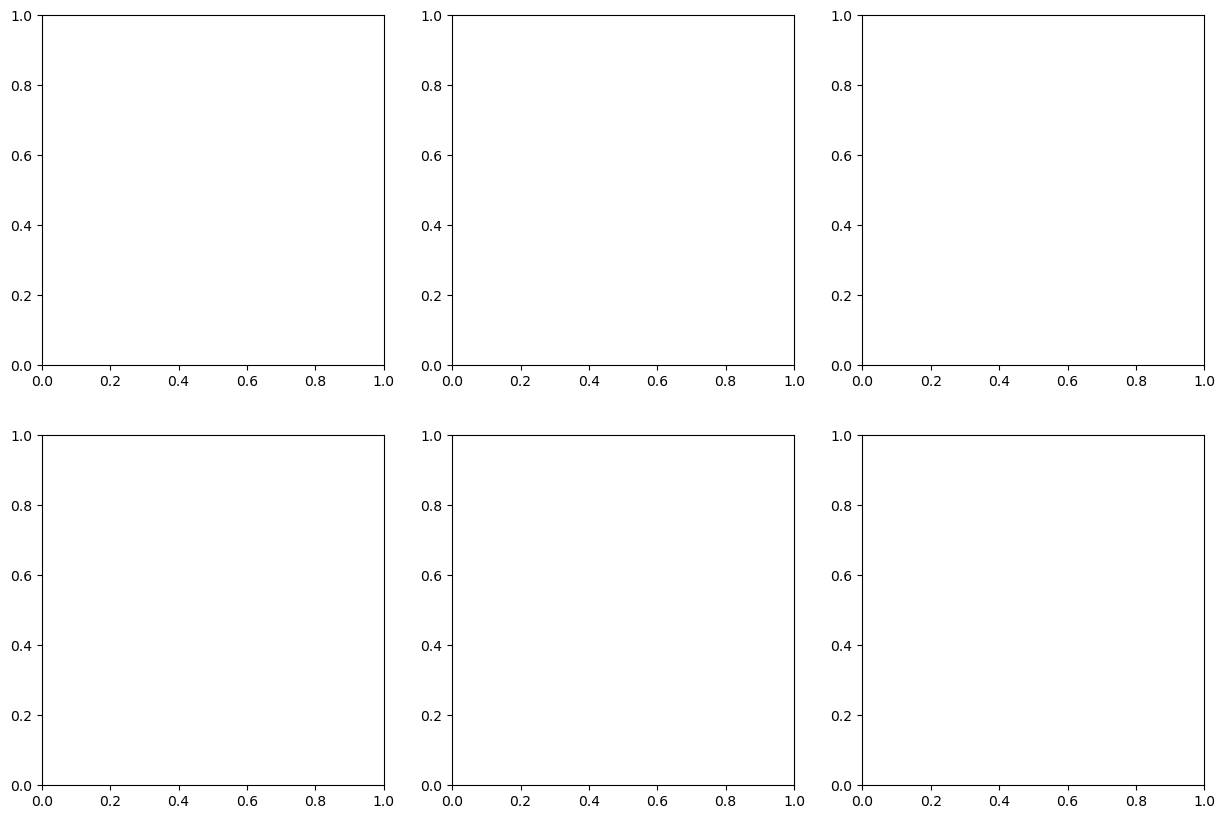

In [13]:
var = 'A1_gdp_net'
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for r_i, r in enumerate(['BHR', 'BRN', 'KWT', 'QAT', 'TTO']):
    ax = axes.flatten()[r_i]
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Variable=var, Region=r, Ccat='C1+C2').Value, label='C1+C2')
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Variable=var, Region=r, Ccat='C3').Value, label="C3")
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Variable=var, Region=r, Ccat='C5+C6').Value, label="C5+C6")
    ax.plot(xr_budgets_scenario.Time, xr_budgets_scenario.sel(Variable=var, Region=r, Ccat='C7').Value, label="C7")
    ax.grid(True)
    ax.set_title(r)
ax.legend()

In [ ]:
check_monotomy('CHN', 'F1g')

1

In [ ]:
fig = go.Figure()
for c_i, c in enumerate(['C1', 'C2', 'C3']):
    bars = go.Bar(name=c,
                  x=['USA', 'EU', "CHN"],
                  y=xr_budgets_static.sel(Region=['USA', 'EU', "CHN"], Ccat=c, Variable='AP').Value)
    fig.add_trace(bars)
fig.update_layout(barmode='group')
fig.show()

KeyError: 'Region is not a valid dimension or coordinate'

## Check budgets AP and GDR

In [ ]:
xr_budgets_static.sel(Region='WORLD', Ccat='C1', Variable='GF').Value

<xarray.DataArray 'Value' ()>
array(1116.261121)
Coordinates:
    Region    <U5 'WORLD'
    Variable  <U2 'GF'
    Ccat      <U2 'C1'

In [ ]:
xr_budgets_static.sel(Region='WORLD', Ccat='C1', Variable='AP').Value

<xarray.DataArray 'Value' ()>
array(1116.218755)
Coordinates:
    Region    <U5 'WORLD'
    Variable  <U2 'AP'
    Ccat      <U2 'C1'

## Check dispersion Approach 2

In [ ]:
vals = np.array(xr_budgets_static.sel(ISO=all_countries, Category='C1+C2').F2)
regs = np.copy(all_countries)
idx = np.argsort(vals)
vals_s = vals[idx]
regs_s = regs[idx]

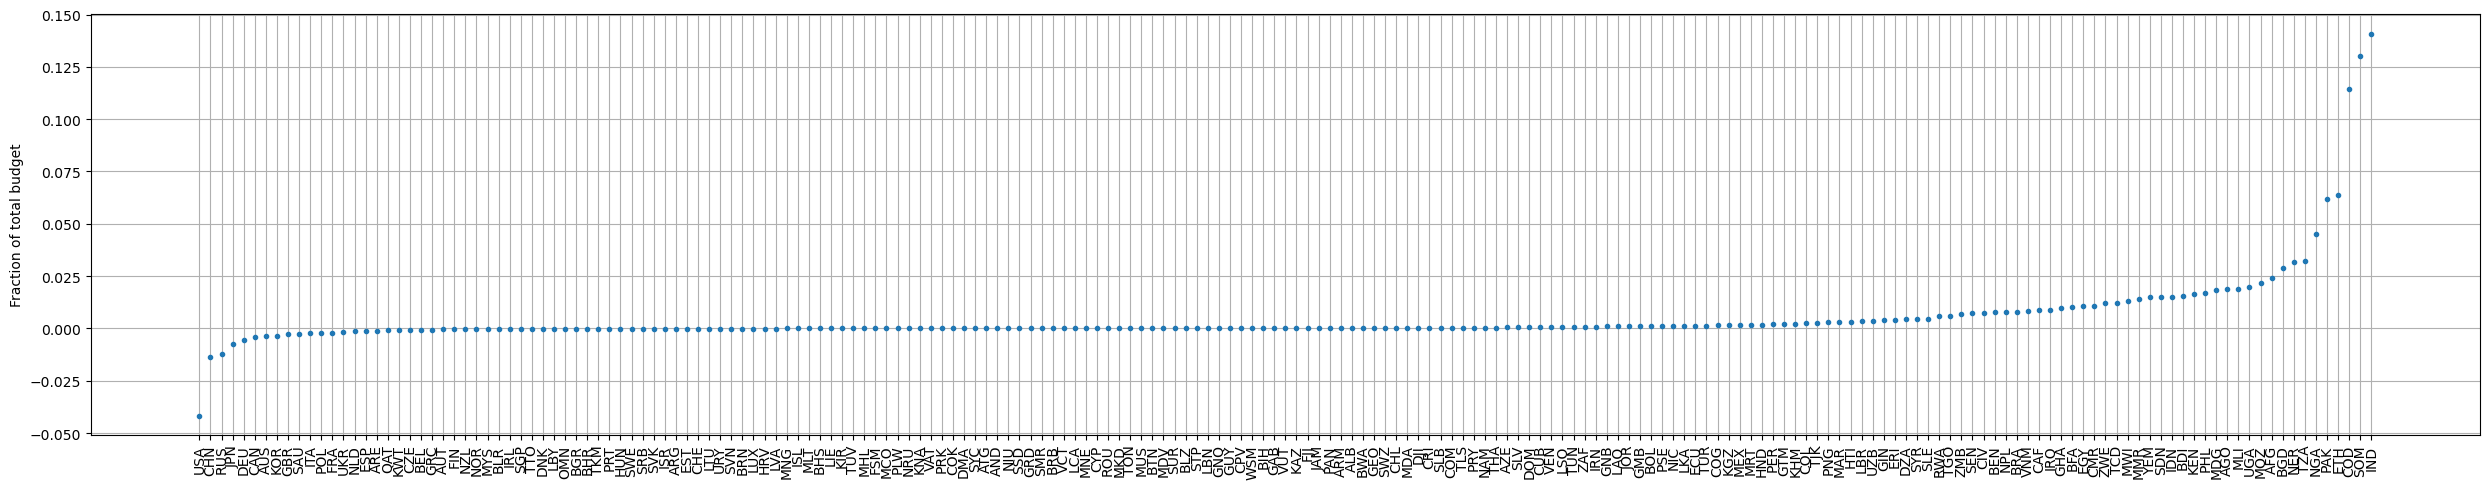

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(regs_s, vals_s/np.nansum(vals_s), '.')
plt.xticks(rotation=90)
plt.ylabel('Fraction of total budget')
fig.tight_layout()
plt.grid('True')
plt.show()

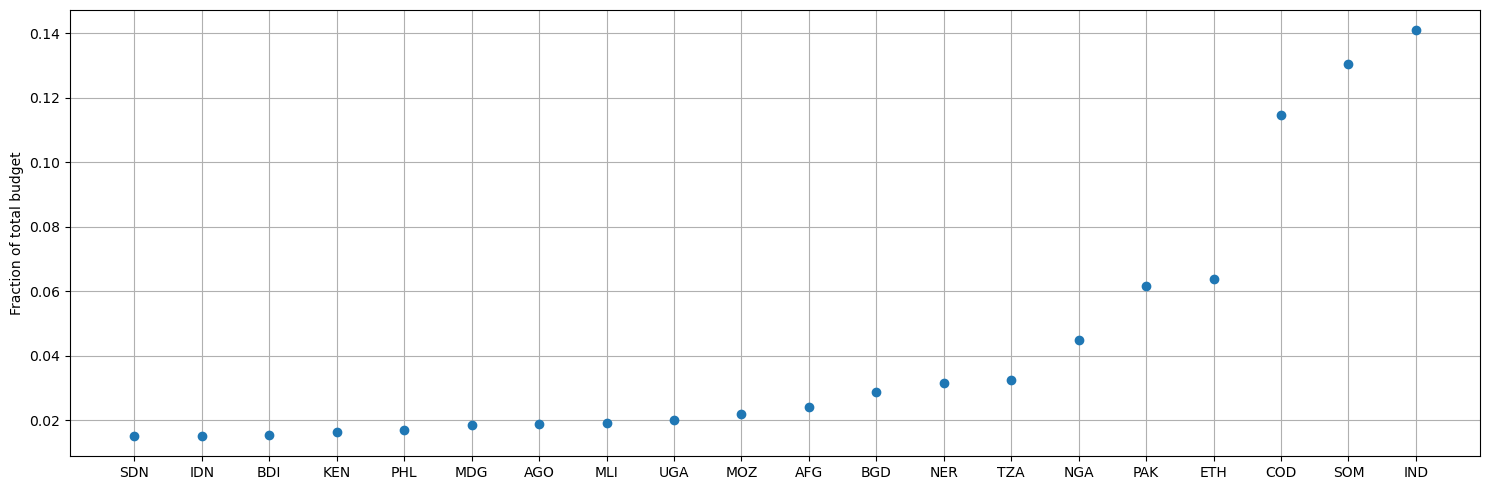

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(regs_s[vals_s/np.nansum(vals_s) > 0.015], (vals_s/np.nansum(vals_s))[vals_s/np.nansum(vals_s) > 0.015], 'o')
plt.ylabel('Fraction of total budget')
fig.tight_layout()
plt.grid('True')
plt.show()